![](/images/blog/biochemical-kinetics-steady-state-combinations.png)

In [yesterday's post](/blog/biochemical-kinetics-reaction-velocities), we did some simple fitting of a [Michaelis-Menten enzyme kinetics model](https://en.wikipedia.org/wiki/Enzyme_kinetics#Michaelis%E2%80%93Menten_kinetics) for a single step of an isolated reaction. What happens when we have multiple reactions with multiple species involved occuring at the same time? Is it possible to infer something about the kinetic parameters of such a system by only looking at the steady-state concentrations of the species in the system under different experimental conditions? In this post, we'll apply some differential equations and simple optimization in Python to try to find out.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1W6e5SOa43QL5oSMiDajn3SlHSajkE_XZ/view?usp=sharing)

<!-- TEASER_END -->

In [0]:
from io import StringIO

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Let's assume we are interested in the following dynamical system:

$$ \frac{dy_1}{dt} = a_{11}y_1 + a_{12}y_2 + b_1 $$
$$ \frac{dy_2}{dt} = a_{21}y_1 + a_{22}y_2 + b_2 $$

where $y_1$ and $y_2$ represent the concentrations of some species with intrinsic growth/decay rates $b_1$ and $b_2$, exponential growth/decay rates $a_{11}$ and $a_{22}$, and exponential conversion rates $a_{12}$ and $a_{21}$, respectively.

Specifically, let's assume we believe that this dynamical system is a good model for an experiment we can perform in the lab in which we measure the steady state concentrations $y_1$ and $y_2$. Let's assume we want to fit this model to experimental data, but we don't know any of the parameter values which control the dynamics of the system.

To solve for steady state solutions, we set both derivatives to zero to obtain the system

$$ 0 = a_{11}\bar{y}_1 + a_{12}\bar{y}_2 + b_1 $$
$$ 0 = a_{21}\bar{y}_1 + a_{22}\bar{y}_2 + b_2 $$

whose solutions are

$$ \bar{y}_1 = \frac{a_{12}b_2 - a_{22}b_1}{a_{11}a_{22} - a_{12}a_{21}} $$
$$ \bar{y}_2 = \frac{a_{21}b_1 - a_{11}b_2}{a_{11}a_{22} - a_{12}a_{21}} $$

This is a system of two equations in six unknowns, so even if we perform a series of repeated experiments on a single system of this form, obtaining measurements for $\bar{y}_1$ and $\bar{y}_2$, we will not be able to uniquely determine any of the values of the parameters underlying the system.

Let's assume, however, that we can perform perturbations on the system which individually perturb the parameters $a_{11}$, $a_{22}$, $a_{12}$, and $a_{21}$ to $a_{11}'$, $a_{22}'$, $a_{12}'$, and $a_{21}'$, respectively. Let's also assume that we can apply these perturbations in arbitrary combinations.

Now, counting all combinations of the perturbations, we have $2 + 4 \times 2 = 10$ unknowns but $2 \times (2^4) = 32$ equations (two for each possible combination of perturbations). Note that not all of these equations are necessarily linearly independent, so the system as a whole may still be underdetermined. Let's assume we are lazy and don't want to identify a smaller set of combinations of parameters which would yield a unique solution.

To represent this system concisely we can think of the separate experiments as rows of a perturbation matrix $P$ and an outcome matrix $Y$ such that the steady state of the $i$th experiment obeys:

$$ y_{i,1} = \frac{(a_{12}p_{i,a_{12}} + a_{12}'p_{i,a_{12}'})b_2 - (a_{22}p_{i,a_{22}} + a_{22}'p_{i,a_{22}'})b_1}{(a_{11}p_{i,a_{11}} + a_{11}'p_{i,a_{11}'})(a_{22}p_{i,a_{22}} + a_{22}'p_{i,a_{22}'}) - (a_{12}p_{i,a_{12}} + a_{12}'p_{i,a_{12}'})(a_{21}p_{i,a_{21}} + a_{21}'p_{i,a_{21}'})} $$
$$ y_{i,2} = \frac{(a_{21}p_{i,a_{21}} + a_{21}'p_{i,a_{21}'})b_1 - (a_{11}p_{i,a_{11}} + a_{11}'p_{i,a_{11}'})b_2}{(a_{11}p_{i,a_{11}} + a_{11}'p_{i,a_{11}'})(a_{22}p_{i,a_{22}} + a_{22}'p_{i,a_{22}'}) - (a_{12}p_{i,a_{12}} + a_{12}'p_{i,a_{12}'})(a_{21}p_{i,a_{21}} + a_{21}'p_{i,a_{21}'})} $$

where $p_{i,a_{11}} = 1$ and $p_{i,a_{11}'} = 0$ if the kinetics of the $i$th experiment are controlled by $a_{11}$, and $p_{i,a_{11}} = 0$ and $p_{i,a_{11}'} = 1$ if the kinetics of the $i$th experiment are controlled by $a_{11}'$.

In [0]:
def y_1(theta, p):
    b_1, b_2, a_11, a_11p, a_22, a_22p, a_12, a_12p, a_21, a_21p = theta
    return (((a_12 * p['a_12'] + a_12p * p['a_12p'])*b_2 -
             (a_22 * p['a_22'] + a_22p * p['a_22p'])*b_1) /
            ((a_11 * p['a_11'] + a_11p * p['a_11p'])*(a_22 * p['a_22'] + a_22p * p['a_22p']) -
             (a_12 * p['a_12'] + a_12p * p['a_12p'])*(a_21 * p['a_21'] + a_21p * p['a_21p'])))
  
def y_2(theta, p):
    b_1, b_2, a_11, a_11p, a_22, a_22p, a_12, a_12p, a_21, a_21p = theta
    return (((a_21 * p['a_21'] + a_21p * p['a_21p'])*b_1 -
             (a_11 * p['a_11'] + a_11p * p['a_11p'])*b_2) /
            ((a_11 * p['a_11'] + a_11p * p['a_11p'])*(a_22 * p['a_22'] + a_22p * p['a_22p']) -
             (a_12 * p['a_12'] + a_12p * p['a_12p'])*(a_21 * p['a_21'] + a_21p * p['a_21p'])))

Let's assume we performed experiments for the following combinations of perturbations (all 16 unique combinations), represented as the following perturbation matrix $P$:

In [0]:
p_str = '''a_11	a_11p	a_12	a_12p	a_21	a_21p	a_22	a_22p
1	0	1	0	1	0	1	0
1	0	1	0	1	0	0	1
1	0	1	0	0	1	1	0
1	0	1	0	0	1	0	1
1	0	0	1	1	0	1	0
1	0	0	1	1	0	0	1
1	0	0	1	0	1	1	0
1	0	0	1	0	1	0	1
0	1	1	0	1	0	1	0
0	1	1	0	1	0	0	1
0	1	1	0	0	1	1	0
0	1	1	0	0	1	0	1
0	1	0	1	1	0	1	0
0	1	0	1	1	0	0	1
0	1	0	1	0	1	1	0
0	1	0	1	0	1	0	1
'''
df = pd.read_csv(StringIO(p_str), sep='\t')
df

,a_11,a_11p,a_12,a_12p,a_21,a_21p,a_22,a_22p
0,1,0,1,0,1,0,1,0
1,1,0,1,0,1,0,0,1
2,1,0,1,0,0,1,1,0
3,1,0,1,0,0,1,0,1
4,1,0,0,1,1,0,1,0
5,1,0,0,1,1,0,0,1
6,1,0,0,1,0,1,1,0
7,1,0,0,1,0,1,0,1
8,0,1,1,0,1,0,1,0
9,0,1,1,0,1,0,0,1


Let's simulate the results of these 16 experiments under the assumption that we know all the parameters. The easiest way to hand-pick guaranteed-physical (i.e., no negative steady state concentrations) is to force $a_{11}$ and $a_{22}$ to be negative and all other rates to be positive, and ensure that $a_{11}a_{22} > a_{12}a_{21}$ for all perturbations.

In [0]:
b_1 = 5.
b_2 = 8.
a_11 = -3.
a_11p = -1.5
a_22 = -4.
a_22p = -2.
a_12 = 0.5
a_12p = 0.25
a_21 = 1.5
a_21p = 0.75
true_theta = np.array([b_1, b_2, a_11, a_11p, a_22, a_22p, a_12, a_12p, a_21, a_21p])

df['y_1'] = y_1(true_theta, df) + np.random.normal(scale=0.25, size=len(df))
df['y_2'] = y_2(true_theta, df) + np.random.normal(scale=0.25, size=len(df))
df

,a_11,a_11p,a_12,a_12p,a_21,a_21p,a_22,a_22p,y_1,y_2
0,1,0,1,0,1,0,1,0,1.703242,2.948070
1,1,0,1,0,1,0,0,1,2.612282,5.908038
2,1,0,1,0,0,1,1,0,1.895743,1.883437
3,1,0,1,0,0,1,0,1,2.153835,5.004029
4,1,0,0,1,1,0,1,0,1.682975,2.437376
5,1,0,0,1,1,0,0,1,2.058915,5.685188
6,1,0,0,1,0,1,1,0,1.685706,2.720532
7,1,0,0,1,0,1,0,1,2.525622,5.051438
8,0,1,1,0,1,0,1,0,4.776790,3.790322
9,0,1,1,0,1,0,0,1,5.790815,8.934292


To fit the model, we can define a least-squares loss function:

In [0]:
def loss(theta):
    y_1_pred = y_1(theta, df)
    y_2_pred = y_2(theta, df)
    return np.sum((y_1_pred - df['y_1'])**2) + np.sum((y_2_pred - df['y_2'])**2)

and then optimize it, starting from 10 random guesses with realistic sign choices:

In [0]:
best_loss = None
best_res = None
bounds = [(0.1, None)] * 2 + [(None, 0.1)] * 4 + [(0.1, None)] * 4
for i in range(10):
    print('.', end='')
    theta_0 = (0.1 + np.random.random(10)) * np.array([1, 1, -1, -1, -1, -1, 1, 1, 1, 1])
    res = minimize(loss, theta_0, bounds=bounds)
    current_loss = loss(res.x)
    if best_loss is None or current_loss < best_loss:
        best_loss = current_loss
        best_res = res
assert best_res.success
best_res.x

..........

array([ 3.33944912,  2.88261337, -2.05303739, -0.95275651, -1.44130753,
       -0.68793415,  0.29705419,  0.13598028,  0.4861968 ,  0.26241915])

This isn't equal to our ground truth parameters, but we can check that it does fit the observed data well (loss after optimization is comparable to the loss given the true theta).

In [0]:
best_loss, loss(true_theta)

(2.314423460881202, 2.7534257619649787)

Therefore, the discrepancy between our fitted parameters and the ground truth parameters is probably due to the fact that the system of equations is not linearly independent.

If the simple optimizer we invoked above was having trouble with local minima in the loss function, we could have tried to fit our model using simulated annealing, but this would take a lot longer and would not lead to a significant improvement in the loss for this particular toy problem:

In [0]:
#from scipy.optimize import basinhopping
#res_bh = basinhopping(loss, theta_0)
#res_bh.x, loss(res_bh.x)

Finally, we can plot the degree of agreement between our fitted model and the experimental results:

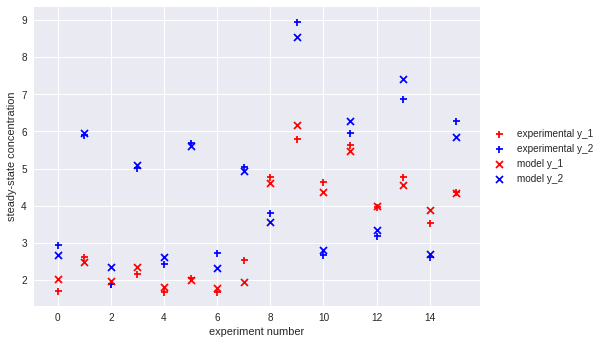

In [0]:
plt.scatter(df.index, df['y_1'], label='experimental y_1', color='r', marker='+')
plt.scatter(df.index, df['y_2'], label='experimental y_2', color='b', marker='+')
plt.scatter(df.index, y_1(best_res.x, df), label='model y_1', color='r', marker='x')
plt.scatter(df.index, y_2(best_res.x, df), label='model y_2', color='b', marker='x')
plt.xlabel('experiment number')
plt.ylabel('steady-state concentration')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()